# Supervised learning with XGBoost

**Updated on:** 2023-02-08 11:24:06 CET

In this Jupyter Notebook we perform supervised learning with xgboost.

**Authors**: Francesco Russo (russof85@gmail.com), Abzer Kelminal (abzer.shah@uni-tuebingen.de)<br>
**Input file format**: .csv files or .txt files <br>
**Outputs**: .csv files, .pdf & .svg images  <br>
**Dependencies**: tidyverse,svglite,xgboost,caret,doParallel)

The session info at the end of this notebook gives info about the versions of all the packages used here.

---

Assuming the user for this notebook has already used the Stats Notebook (Performing basic uni- and multivariate statistical analsysis of untargeted metabolomics data) [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Functional-Metabolomics-Lab/Statistical-analysis-of-non-targeted-LC-MSMS-data/blob/main/Stats_Untargeted_Metabolomics.ipynb) , we will proceed with loading in necessary files and perform XGBoost

In [47]:
options(install.packages.compile.from.source="never")

In [ ]:
install.packages(c("tidyverse","svglite","xgboost","caret","doParallel"),dependencies=T)

In [37]:
#calling all libraries
lib_list <- c("tidyverse","svglite","xgboost","caret","doParallel") # creating a vector of all the necessary libraries
invisible(sapply(lib_list,  suppressPackageStartupMessages(library), character.only = TRUE)) #applying library call on each element of lib_list

In [38]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22000)

Matrix products: default

locale:
[1] LC_COLLATE=English_United Kingdom.1252 
[2] LC_CTYPE=English_United Kingdom.1252   
[3] LC_MONETARY=English_United Kingdom.1252
[4] LC_NUMERIC=C                           
[5] LC_TIME=English_United Kingdom.1252    

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] doParallel_1.0.17 iterators_1.0.14  foreach_1.5.2     caret_6.0-93     
 [5] lattice_0.20-45   xgboost_1.7.1.1   svglite_2.1.1     forcats_1.0.0    
 [9] stringr_1.5.0     dplyr_1.1.0       purrr_1.0.1       readr_2.1.3      
[13] tidyr_1.3.0       tibble_3.1.8      ggplot2_3.4.0     tidyverse_1.3.2  

loaded via a namespace (and not attached):
 [1] nlme_3.1-161         fs_1.6.0             lubridate_1.9.1     
 [4] httr_1.4.4           repr_1.1.6           tools_4.1.3         
 [7

- <b>"attached base packages"</b> are the packages that come with R and we do not need to install them. 
- <b>"other attached packages"</b>  are the packages we installed and loaded by library(). We can call all the functions belonging to the attached packages by just specifying the function name.
- <b>"loaded via a namespace (and not attached)"</b> are the packages that are downloaded as dependencies to the installed packages. We can call them by namespace "::" such as data.table::fread() which refers to fread() from data.table

# Load in the cleaned up table and metadata:

In [15]:
#setting a working directory
Directory <- normalizePath(readline("Enter the path of the folder with input files: "),"/",mustWork=FALSE)
setwd(Directory)

Enter the path of the folder with input files:  D:\Projects\Hitchhiker\xgboost_tuning


In [17]:
file_list <- print(list.files('.'))

[1] "2023-02-02_ft_md_merged_after_cleanup.csv"      
[2] "2023-02-02_ft_md_merged_before_data_cleanup.csv"


Lets load the feature table (after datacleanup: Blank removal and Imputation, scaling) merged with metadata (metadata with Blanks). 

In [18]:
Data <- data.table::fread(file_list[1]) 

In [19]:
head(Data)

V1,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,...,X9833_268.175_2.821,X9860_240.144_2.824,X9876_414.139_2.761,X9884_190.05_2.832,X9897_333.144_2.881,X9909_400.16_2.813,X9918_252.123_2.833,X9957_402.139_3.01,X9972_323.123_2.716,X9995_276.159_2.805
<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,...,0.50953425,0.3411530,-0.9690079,-0.2136334,-1.0317304,-0.3097998,-0.177995,1.1679223,-0.9536029,-0.720846274
2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,...,0.09238905,0.5326194,1.0516269,-0.3038794,-0.1930184,-0.7478181,1.252001,0.9551530,-0.9361819,-0.008639177
3,SD_01-2018_10_a.mzXML,Sample,2,Jan,2018,10,a,10,32.86261,...,-0.24639335,-0.2865859,4.3836879,-0.6676765,-0.4632050,4.5197644,2.438135,-0.7384554,1.9221174,0.486389335
4,SD_01-2018_10_b.mzXML,Sample,2,Jan,2018,10,b,10,32.86261,...,-0.25192058,-0.2285435,0.4843269,-0.5684610,1.5535042,-0.8303057,1.434401,4.0595393,0.6681850,0.985037345
5,SD_01-2018_11_a.mzXML,Sample,2,Jan,2018,11,a,11,32.85601,...,-0.28563018,-0.2476378,1.5809568,-0.6620708,0.3906509,-0.6962297,2.185162,-0.5521619,0.4461508,1.021271440
6,SD_01-2018_11_b.mzXML,Sample,2,Jan,2018,11,b,11,32.85601,...,-0.24677023,-0.2403817,0.3811471,-0.6653472,-1.1098859,3.4050080,1.824056,-0.6258216,-0.7639999,-0.815254939


In [20]:
Data <- Data[,-1] #removing the 1st column with row numbers

Add a column named 'ATTRIBUTE_rainfall' as a binary class. The samples retrieved in January are encoded as 1 while all the other months are encoded as 0.

In [21]:
Data <- Data %>% add_column(ATTRIBUTE_rainfall=ifelse(Data$ATTRIBUTE_Month=="Jan",1,0),
                          .before = 10) #adding the column before 10th column. You can define any number; we define it 10 because metadata info are in the beginning columns

In [23]:
print(colnames(Data)[1:20]) #looking at the first 20 column names to see if ATTRIBUTE_rainfall is added. By using print() we get the index number

 [1] "filename"                  "ATTRIBUTE_Sample.Type"    
 [3] "ATTRIBUTE_Batch"           "ATTRIBUTE_Month"          
 [5] "ATTRIBUTE_Year"            "ATTRIBUTE_Sample_Location"
 [7] "ATTRIBUTE_Replicate"       "ATTRIBUTE_Spot"           
 [9] "ATTRIBUTE_Latitude"        "ATTRIBUTE_rainfall"       
[11] "ATTRIBUTE_Longitude"       "ATTRIBUTE_Sample_Area"    
[13] "ATTRIBUTE_Spot_Name"       "ATTRIBUTE_time_run"       
[15] "ATTRIBUTE_Injection_order" "X10015_282.169_2.763"     
[17] "X10035_325.139_2.817"      "X10037_216.123_2.847"     
[19] "X10047_338.159_2.845"      "X10058_280.117_2.961"     


In [24]:
# Distribution of binary class:
table(Data$ATTRIBUTE_rainfall) #table() tabulates the different categories in the column


  0   1 
120  60 

Thus, 120 files belong to level '0' and 60 files in level '1'.

In [25]:
# metadata
head(Data[,1:15], n=3) #Looking at the first 15 columns of Data; n=3 shows the first 3 rows

filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_rainfall,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order
<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,1,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:36,65
SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,1,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:52,66
SD_01-2018_10_a.mzXML,Sample,2,Jan,2018,10,a,10,32.86261,1,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,16/01/2018 16:23,83


In [26]:
# metabolomics data
head(Data[,16:ncol(Data)], n=3)

X10015_282.169_2.763,X10035_325.139_2.817,X10037_216.123_2.847,X10047_338.159_2.845,X10058_280.117_2.961,X10059_414.175_2.851,X10072_305.157_2.851,X10074_283.175_2.851,X10078_300.201_2.851,X10082_309.144_2.886,...,X9833_268.175_2.821,X9860_240.144_2.824,X9876_414.139_2.761,X9884_190.05_2.832,X9897_333.144_2.881,X9909_400.16_2.813,X9918_252.123_2.833,X9957_402.139_3.01,X9972_323.123_2.716,X9995_276.159_2.805
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1.1304738,-0.2996871,-0.1117275,2.2186171,-1.452146,-0.17593037,-0.3434611,-0.1778404,-0.1933466,-0.98676658,...,0.50953425,0.3411530,-0.9690079,-0.2136334,-1.0317304,-0.3097998,-0.177995,1.1679223,-0.9536029,-0.720846274
-1.1265155,-0.6037355,1.9885898,0.2986375,-1.028317,0.38485813,-0.3749450,-0.1894778,-0.1876122,0.01064504,...,0.09238905,0.5326194,1.0516269,-0.3038794,-0.1930184,-0.7478181,1.252001,0.9551530,-0.9361819,-0.008639177
-0.6995949,-0.4612301,-0.3618842,1.2580121,0.747262,-0.05869551,-0.4289946,-0.2615139,-0.2501572,-0.56453788,...,-0.24639335,-0.2865859,4.3836879,-0.6676765,-0.4632050,4.5197644,2.438135,-0.7384554,1.9221174,0.486389335


# Prepare input data: split train and test sets
<a id="train_test"></a>

We divide the feature table (metabolomics data) into training and test sets. According to the sample size, we can split the data to obtain 80% for the train and 20% for the test sets. In our case, we have a relatively small sample size, therefore we will use 70% of the data for the train and 30% for the test set to have enough samples in each class.

Then, we will use the eXtreme Gradient Boosting (XGBoost) algorithm to predict the rainfall variable.
Useful info: <a href="https://xgboost.readthedocs.io/en/stable/R-package/xgboostPresentation.html">R package for training an XGBoost model</a>, <a href="https://topepo.github.io/caret/">R package 'Caret' for training different machine learning models</a>

<b> Critical</b>: When our class of interest is binary and unbalanced, we need to be mindful of it while training our XGBoost model. In such cases, we can use the parameter <a href="https://xgboost.readthedocs.io/en/latest/parameter.html">scale_pos_weight</a>, where a typical value to consider is sum(negative instances) / sum(positive instances).

In [216]:
set.seed(1234) # Set random seed to make results reproducible
trainIndex <- caret::createDataPartition(Data$ATTRIBUTE_Sample_Area, 
                                         p = 0.7, #percentage of data to train
                                         list = FALSE, # indicating that the results do not need to be in a list
                                         times = 1) # the number of partitions to create

ftTrain <- Data[trainIndex,] #all the rows from Data based on the trainIndex will be taken as train
ftTest  <- Data[-trainIndex,] #the remaining rows from Data will be taken as test set

In [95]:
head(ftTrain, n=2)
head(ftTest, n=2)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_rainfall,...,X9833_268.175_2.821,X9860_240.144_2.824,X9876_414.139_2.761,X9884_190.05_2.832,X9897_333.144_2.881,X9909_400.16_2.813,X9918_252.123_2.833,X9957_402.139_3.01,X9972_323.123_2.716,X9995_276.159_2.805
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_b.mzXML,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,1,...,0.09238905,0.5326194,1.051627,-0.3038794,-0.1930184,-0.7478181,1.252001,0.9551530,-0.9361819,-0.008639177
SD_01-2018_10_a.mzXML,SD_01-2018_10_a.mzXML,Sample,2,Jan,2018,10,a,10,32.86261,1,...,-0.24639335,-0.2865859,4.383688,-0.6676765,-0.4632050,4.5197644,2.438135,-0.7384554,1.9221174,0.486389335


,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_rainfall,...,X9833_268.175_2.821,X9860_240.144_2.824,X9876_414.139_2.761,X9884_190.05_2.832,X9897_333.144_2.881,X9909_400.16_2.813,X9918_252.123_2.833,X9957_402.139_3.01,X9972_323.123_2.716,X9995_276.159_2.805
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_01-2018_1_a.mzXML,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,1,...,0.5095343,0.341153,-0.9690079,-0.2136334,-1.0317304,-0.3097998,-0.177995,1.167922,-0.9536029,-0.7208463
SD_01-2018_12_b.mzXML,SD_01-2018_12_b.mzXML,Sample,2,Jan,2018,12,b,12,32.85161,1,...,-0.2436331,-0.242753,1.8453228,-0.5062281,-0.5210866,-0.7371961,1.232944,2.883112,-0.7343786,-0.4035639


Looking at the dimension of the test and train sets:

In [96]:
dim(ftTrain) # 130 rows or files as train data
dim(ftTest) # 50 rows or files as test data

[1]  130 9107

[1]   50 9107

Lets have a look at the class distribution of these train and test sets to see if the data is distributed among all categories.

In [97]:
table(ftTrain$ATTRIBUTE_Sample_Area) #class distribution for train


     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                 26                   9                  26                  13 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                  9                  13                  34 

In [98]:
table(ftTest$ATTRIBUTE_Sample_Area) #class distribution for test


     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                 10                   3                  10                   5 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                  3                   5                  14 

In [99]:
# prepare input data (feature table and binary class) for XGBoost:
train_x <- ftTrain[,16:ncol(ftTrain)] # metabolomics data
train_y <- as.factor(ftTrain$ATTRIBUTE_Sample_Area) # variable of interest

test_x <- ftTest[,16:ncol(ftTest)] # metabolomics data
test_y <- as.factor(ftTest$ATTRIBUTE_Sample_Area) # variable of interest

In [100]:
dim(train_x)
table(train_y)

dim(test_x)
table(test_y)

[1]  130 9092

train_y
     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                 26                   9                  26                  13 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                  9                  13                  34 

[1]   50 9092

test_y
     La_Jolla Reefs       La_Jolla_Cove         Mission_Bay       Mission_Beach 
                 10                   3                  10                   5 
      Pacific_Beach SIO_La_Jolla_Shores        Torrey_Pines 
                  3                   5                  14 

# XGBoost model with default parameters
<a id="xgboost_def"></a>
First, we perform the analysis without tuning the [parameters](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster), by using default/recommended parameters to see how our basic XGBoost model performs.

In [101]:
# register eight cores on the same machine for parallel computing --> to increase the speed of R to perform XGBoost
n_threads <- 8 # this parameter is used by XGBoost
cl <- parallel::makePSOCKcluster(n_threads)
registerDoParallel(cl)

In [102]:
# All the parameters are defined with their default values:
grid_default <- expand.grid(
    nrounds = 500, #no.of iterations
    max_depth = 6, #maximum depth of a decision tree
    eta = 0.3, #learning rate
    gamma = 0, # regularization parameter (0=no regularization): Increasing the gamma will make the algorithm mre conservative
    subsample = 1, # sampling ratio for training. XGBoost would randomly sample all the training data before growing trees to prevent overfitting
    colsample_bytree = 1, #subsample ratio of columns when constructing a tree
    min_child_weight = 1 #minimum sum of hessian weights needed in a child
)

In [120]:
grid_default

nrounds,max_depth,eta,gamma,subsample,colsample_bytree,min_child_weight
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
500,6,0.3,0,1,1,1


In [103]:
train_control <- caret::trainControl(
    method = "none", #here we can specify the resampling model; "None" only fits one model to the entire training set
    verboseIter = FALSE, #by FALSE, we don't print the output of training log, which keeps track of successes while training.
    allowParallel = TRUE #if a parallel (computing) backend is available, consider it
)

In [104]:
set.seed(1234)
xgb_base <- caret::train(
    x = train_x,  # metabolomics data
    y = train_y,  # variable of interest: ATTRIBUTE_Sample_Area in our case
    trControl = train_control, # a list of values defining how the function should act
    tuneGrid = grid_default, # using the default parameters for tuning
    method = "xgbTree", # specify which classification or regression model to train
    verbose = TRUE, # to see the progress of training process
    #scale_pos_weight = scalePosWeight,
    nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [105]:
gc() # free memory
xgb_base

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2694722,144.0,4253282,227.2,4253282,227.2
Vcells,8195199,62.6,21357184,163.0,17651681,134.7


Now, we are going to use this model to predict the test set and show the performance in a 'confusion matrix'. More information about the statistics can be found at https://rdrr.io/cran/caret/man/confusionMatrix.html.

In [107]:
# predict on test data
predicted_base <- predict(xgb_base, test_x)
# performance
confusionMatrix(data = predicted_base,  #the predicted results
                reference = test_y, #predictions are compared with the test_y (metadata info)
                positive = '1',
                mode = 'everything')

Confusion Matrix and Statistics

                     Reference
Prediction            La_Jolla Reefs La_Jolla_Cove Mission_Bay Mission_Beach
  La_Jolla Reefs                   8             0           0             0
  La_Jolla_Cove                    0             2           0             0
  Mission_Bay                      0             0          10             1
  Mission_Beach                    0             0           0             4
  Pacific_Beach                    2             0           0             0
  SIO_La_Jolla_Shores              0             1           0             0
  Torrey_Pines                     0             0           0             0
                     Reference
Prediction            Pacific_Beach SIO_La_Jolla_Shores Torrey_Pines
  La_Jolla Reefs                  1                   1            0
  La_Jolla_Cove                   0                   0            0
  Mission_Bay                     1                   0            0
  Mission_Bea

Let's look at the probability matrix. It shows the probability of a sample belonging to a particular sampling area

In [218]:
prediction_probs_base <- predict(xgb_base, test_x, type = "prob") # predict the probability matrix for each sampling area
head(prediction_probs_base)

,La_Jolla Reefs,La_Jolla_Cove,Mission_Bay,Mission_Beach,Pacific_Beach,SIO_La_Jolla_Shores,Torrey_Pines
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.005248298,0.016946796,0.021387147,0.003624770,0.002733320,0.035340570,0.914719105
2,0.024278818,0.349722177,0.063845120,0.086620703,0.052364636,0.402189225,0.020979339
3,0.858547628,0.007774164,0.010009320,0.011996829,0.026113506,0.077554032,0.008004516
4,0.169616744,0.005782446,0.020781940,0.010862703,0.781848848,0.005518070,0.005589298
5,0.119383901,0.006615007,0.009400726,0.035312124,0.815334857,0.007559339,0.006394048
6,0.004444454,0.020675076,0.019218670,0.007734112,0.003753883,0.019449066,0.924724698


In [217]:
#to build multiple ROC curve to compute the multi-class AUC 
ROC_base <- pROC::multiclass.roc(test_y, prediction_probs_base) 
ROC_base$auc # AUC

Multi-class area under the curve: 0.902

# Tuning parameters in XGBoost
<a id="xgboost_tune"></a>

## 1. Tuning Number of Iterations and the Learning Rate
A high number of iterations (nrounds) makes the algorithm slower but at the same time we need a good number of iterations for testing several combinations of parameters. The number of folds in the cross-validation can also slow down the computation. Just to show how this works, here we set nrounds=500 and number of folds = 5. You can also try increasing these numbers to nrounds=1000 and number of folds = 10.

In [113]:
nrounds <- 500 #no.of iterations

In [115]:
tune_grid <- expand.grid(
  nrounds = seq(from = 100, to = nrounds, by = 10), #sequence of values from 100 to 500 increased by 10
  eta = c(0.025, 0.05, 0.1, 0.3), #learning rate
  max_depth = seq(from = 2, to = 10, by = 2), #max depth of a decision tree
  #max_depth = 6,
  gamma = 0, #default value
  colsample_bytree = 1, #default value
  min_child_weight = 1, #default value
  subsample = 1 #default value
)

In [119]:
head(tune_grid)

,nrounds,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,100,0.025,2,0,1,1,1
2,110,0.025,2,0,1,1,1
3,120,0.025,2,0,1,1,1
4,130,0.025,2,0,1,1,1
5,140,0.025,2,0,1,1,1
6,150,0.025,2,0,1,1,1


In [121]:
tail(tune_grid) #last 6 values of the dataframe. As you can see, eta and max_depth range are changing as well

,nrounds,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
815,450,0.3,10,0,1,1,1
816,460,0.3,10,0,1,1,1
817,470,0.3,10,0,1,1,1
818,480,0.3,10,0,1,1,1
819,490,0.3,10,0,1,1,1
820,500,0.3,10,0,1,1,1


In [116]:
tune_control <- caret::trainControl(
  method = "cv", # cross-validation
  number = 5, # number of folds
  repeats = NA,
  verboseIter = FALSE,
  allowParallel = TRUE
)

<font color="red"><b>Critical:</b> It will take about 16-20 mins to run the next cell.</font>

In [123]:
set.seed(1234)
xgb_tune <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control, #here tune_control with 5-fold cross validation is used to define the trainControl
  tuneGrid = tune_grid, #using the tune_grid dataframe for tuning
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [135]:
gc() #freeing RAM memory

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2743054,146.5,4253282,227.2,4253282,227.2
Vcells,8598391,65.7,21357184,163.0,17651681,134.7


## 2. Tuning Maximum Depth and Minimum Child Weight

In [134]:
xgb_tune$bestTune #getting the best tuning parameter from the previous tuned model

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
616,100,2,0.3,0,1,1,1


In [136]:
tune_grid2 <- expand.grid(
  nrounds = seq(from = 100, to = nrounds, by = 10),
  eta = xgb_tune$bestTune$eta, #choosing the best-tuned learning rate
  max_depth = ifelse(xgb_tune$bestTune$max_depth == 2, #test if the best-tuned max_depth value is 2
                     c(xgb_tune$bestTune$max_depth:10), #if yes, then consider max_depth range from 2 to 10
                     (xgb_tune$bestTune$max_depth - 1):(xgb_tune$bestTune$max_depth + 1)), #if not, consider max_depth range from 1 value below best_tuned max_depth until 1 value above. 
  gamma = 0, #default
  colsample_bytree = 1, #default value
  min_child_weight = c(1, 2, 3), #range of 1 to 3
  subsample = 1 #default value
)

<font color="red"><b>Critical:</b> It will take about 10 mins to run the next cell.</font>

In [137]:
set.seed(1234)
xgb_tune2 <- caret::train( #training anotehr model with these tuned parameters
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid2,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

## 3. Tuning Column and Row Sampling

Getting the best parameters from the previous tuning:

In [139]:
xgb_tune2$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,100,2,0.3,0,1,1,1


- So far, in the first xgb model, we tried to tune the Tuning Number of Iterations(nrounds) and Learning Rate(eta). 
- We used the best eta from 1st model and tuned the second model(xgb_tune2) for different values of Maximum Depth and Minimum Child Weight.
- For the next model xgb_tune3, we choose best_eta from xgb_tune and best values of <b>max_depth</b> and <b>min_child_weight</b> from xgb_tune2. Using these parameters, we are tuning <b>colsample_bytree</b> and <b>subsample.</b>

<b>subsample</b> is defined as the sampling ratio for training. If it is 0.5, then XGBoost would randomly sample half of the training data before growing trees to prevent overfitting. <br>
<b>colsample_bytree</b> is the subsample ratio of columns when constructing a decision tree.

In [142]:
tune_grid3 <- expand.grid(
  nrounds = seq(from = 100, to = nrounds, by = 10),
  eta = xgb_tune$bestTune$eta,
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = 0,
  colsample_bytree = c(0.4, 0.6, 0.8, 1.0),
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = c(0.5, 0.75, 1.0)
)

<font color="red"><b>Critical:</b> It will take about 4-5 mins to run the next cell.</font>

In [143]:
set.seed(1234)
xgb_tune3 <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid3,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [148]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2776389,148.3,4253282,227.2,4253282,227.2
Vcells,9180952,70.1,21357184,163.0,17651681,134.7


## 4. Tuning Gamma

Gamma is a regularization parameter (0=no regularization). Increasing the gamma will make the algorithm more conservative

In [145]:
xgb_tune3$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
206,100,2,0.3,0,0.6,1,1


In [146]:
tune_grid4 <- expand.grid(
  nrounds = seq(from = 100, to = nrounds, by = 10),
  eta = xgb_tune$bestTune$eta,
  max_depth = xgb_tune2$bestTune$max_depth,
  gamma = c(0, 0.05, 0.1, 0.5, 0.7, 0.9, 1.0), #defining a range of gamma values
  colsample_bytree = xgb_tune3$bestTune$colsample_bytree,
  min_child_weight = xgb_tune2$bestTune$min_child_weight,
  subsample = xgb_tune3$bestTune$subsample
)

<font color="red"><b>Critical:</b> It will take about 5-10 mins to run the next cell.</font>

In [147]:
set.seed(1234)
xgb_tune4 <- caret::train(
  x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid4,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [149]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2776388,148.3,4253282,227.2,4253282,227.2
Vcells,9180658,70.1,21357184,163.0,17651681,134.7


## 5. Reducing the Learning Rate

In [150]:
xgb_tune4$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42,100,2,0.3,0.05,0.6,1,1


Recap: <br>
- xgb_tune: Tuned nrounds and eta
- xgb_tune2: Tuned max_depth and min_child_weight
- xgb_tune3: Tuned colsample_bytree and subsample
- xgb_tune4: Tuned gamma

In [151]:
tune_grid5 <- expand.grid(
  nrounds = seq(from = 100, to = 1000, by = 100), #nrounds from 100 to 1000 incremented by 100
  eta = c(0.01, 0.015, 0.025, 0.05, 0.1), #range of values for learning rate
  max_depth = xgb_tune2$bestTune$max_depth, 
  gamma = xgb_tune4$bestTune$gamma, 
  colsample_bytree = xgb_tune3$bestTune$colsample_bytree,  
  min_child_weight = xgb_tune2$bestTune$min_child_weight,  
  subsample = xgb_tune3$bestTune$subsample 
)

<font color="red"><b>Critical:</b> It will take about 5-10 mins to run the next cell.</font>

In [152]:
set.seed(1234)
xgb_tune5 <- caret::train(
    x = train_x, y = train_y,
  trControl = tune_control,
  tuneGrid = tune_grid5,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [155]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2786924,148.9,4253282,227.2,4253282,227.2
Vcells,9367658,71.5,21357184,163.0,17651681,134.7


## 6. Fitting the final model using the best parameters from the previous step

Since xgb_tune5 used all the best parameters from the previous 4 tuning models, we will use the best paramaters of xgb_tune5 to fit the final model.

In [156]:
xgb_tune5$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42,200,2,0.1,0.05,0.6,1,1


In [157]:
final_grid <- expand.grid(
  nrounds = xgb_tune5$bestTune$nrounds,
  eta = xgb_tune5$bestTune$eta,
  max_depth = xgb_tune5$bestTune$max_depth,
  gamma = xgb_tune5$bestTune$gamma,
  colsample_bytree = xgb_tune5$bestTune$colsample_bytree,
  min_child_weight = xgb_tune5$bestTune$min_child_weight,
  subsample = xgb_tune5$bestTune$subsample
)

In [158]:
set.seed(1234)
xgb_model_final <- caret::train(
  x = train_x, y = train_y,
  trControl = train_control,
  tuneGrid = final_grid,
  method = "xgbTree",
  verbose = TRUE,
  nthread = n_threads # for parallel computing; it indicates the number of threads
)

In [159]:
predicted_final <- predict(xgb_model_final, test_x) # predict on test data
confusionMatrix(data = predicted_final, reference = test_y) #getting the confusion matrix

Confusion Matrix and Statistics

                     Reference
Prediction            La_Jolla Reefs La_Jolla_Cove Mission_Bay Mission_Beach
  La_Jolla Reefs                   8             0           0             0
  La_Jolla_Cove                    0             3           0             0
  Mission_Bay                      0             0           9             1
  Mission_Beach                    0             0           1             4
  Pacific_Beach                    2             0           0             0
  SIO_La_Jolla_Shores              0             0           0             0
  Torrey_Pines                     0             0           0             0
                     Reference
Prediction            Pacific_Beach SIO_La_Jolla_Shores Torrey_Pines
  La_Jolla Reefs                  2                   0            0
  La_Jolla_Cove                   0                   0            0
  Mission_Bay                     1                   0            0
  Mission_Bea

In [160]:
prediction_probs_tuned <- predict(xgb_model_final, test_x, type = "prob") # get the probability matrix

In [208]:
head(prediction_probs_tuned,3)
dim(prediction_probs_tuned)

,La_Jolla Reefs,La_Jolla_Cove,Mission_Bay,Mission_Beach,Pacific_Beach,SIO_La_Jolla_Shores,Torrey_Pines
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.001268527,0.00936424,0.011528916,0.001488929,0.001018551,0.006796387,0.968534470
2,0.017003052,0.55707443,0.043532647,0.025914976,0.024973545,0.319260716,0.012240668
3,0.877113283,0.00560596,0.008318624,0.011489893,0.014193409,0.079620928,0.003657874


[1] 50  7

In [161]:
ROC_tuned <- pROC::multiclass.roc(test_y, prediction_probs_tuned) #ROC
ROC_tuned$auc #AUC

Multi-class area under the curve: 0.957

In [162]:
gc() # free memory

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2798138,149.5,4253282,227.2,4253282,227.2
Vcells,9545158,72.9,21357184,163.0,17651681,134.7


In [163]:
stopCluster(cl) # stop cluster

From tuning parameters in 5-fold cross-validation, we obtained an improvement in performance and the final AUC is 0.96 and Accuracy is 0.84. Again, remember that our sample size is not very large and it needs to be considered in any predictive task. The code here is intended to provide you a guide for building an XGBoost model and tuning important parameters but a particular attention is needed when building these models to avoid issues such as overfitting/underfitting and reaching wrong conclusions. 

# Ranking features by importance
<a id="xgboost_rank"></a>
We can also rank the feature by importance. The top features had a larger impact on determining the prediction of sampling area. Note that the R package caret estimates feature importance from the final model fitted, and not from the cross-validations. This is automatically given to the caret function varImp.

In [177]:
varImp(xgb_model_final, scale = T)

xgbTree variable importance

  only 20 most important variables shown (out of 9092)

                       Overall
X92112_906.258_12.941  100.000
X54129_381.808_6.99     63.228
X91372_906.258_12.697   46.987
X59188_312.231_7.625    32.354
X57492_331.081_7.416    26.050
X86594_755.487_11.127   24.848
X91699_932.629_12.77    21.801
X89535_1223.342_12.013  18.177
X83607_480.549_10.728   18.158
X33200_260.196_4.886    17.571
X89481_856.607_11.931   16.659
X89388_908.258_12.002   16.125
X79387_209.153_10.22    12.613
X282_261.108_0.615      12.366
X46443_363.165_6.106    10.629
X54623_486.363_7.052    10.035
X48714_566.104_6.378     9.433
X82651_261.242_10.62     9.121
X78984_219.174_10.107    8.621
X55979_529.37_7.232      8.547

To write down the 'gain' or importance score for all features, we will use the xgb.importance function from xgboost package.

In [179]:
var_imp <- xgboost::xgb.importance(xgb_model_final$finalModel$feature_names,model=xgb_model_final$finalModel)
head(var_imp)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
X92112_906.258_12.941,0.11284244,0.05321790,0.026856240
X54129_381.808_6.99,0.07134831,0.03630356,0.024486572
X91372_906.258_12.697,0.05302117,0.02989660,0.011848341
X59188_312.231_7.625,0.03650904,0.02709749,0.016587678
X57492_331.081_7.416,0.02939598,0.01388229,0.003949447
X86594_755.487_11.127,0.02803867,0.03454048,0.024486572


In [180]:
write.csv(var_imp, "Importance_features_xgboost.csv")

We can also plot the top 20 features. Change the 'top' parameter for plotting more features. The feature importance is based on the 'Gain' calculation. For more details https://xgboost.readthedocs.io/en/latest/tutorials/model.html

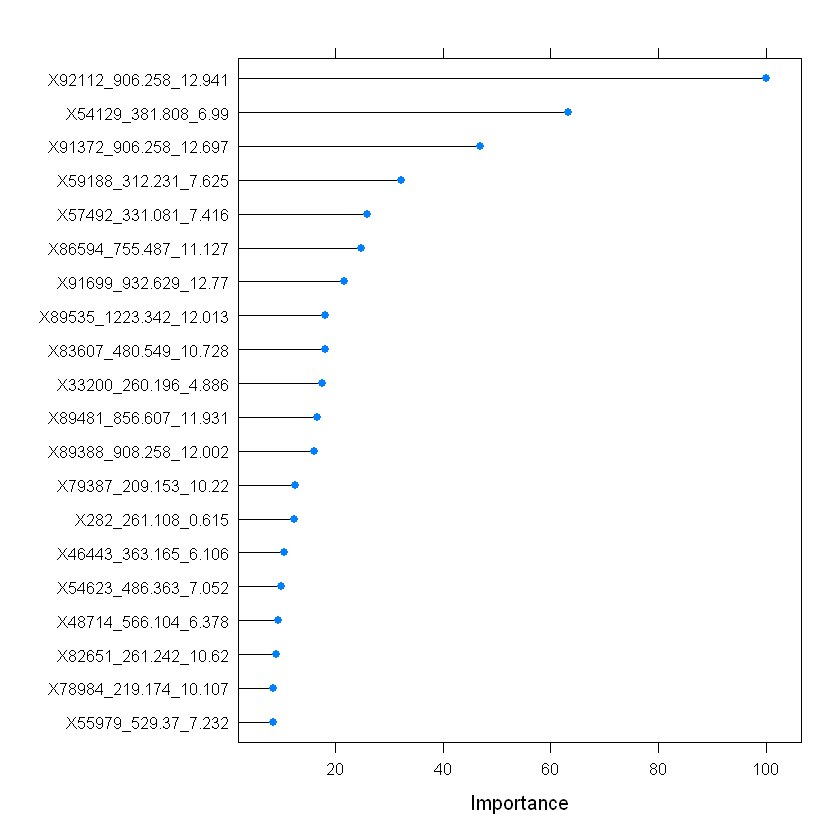

In [165]:
plot(varImp(xgb_model_final, scale = T), top = 20)

In [ ]:
svglite('top20_important_features_xgboost.svg', width=10, height=15, bg='white') #to save as svg plot
plot(varImp(xgb_model_final, scale = T), top = 20)
dev.off()